![](./img/chinahadoop.png)
# 卷积神经网络文本分类
**[小象学院](http://www.chinahadoop.cn/course/landpage/15)《机器学习集训营》课程资料 by [@寒小阳](http://www.chinahadoop.cn/user/49339/about)**

## 原理讲解
TextCNN出处：论文[Convolutional Neural Networks for Sentence Classification](http://www.aclweb.org/anthology/D14-1181)

### 论文核心点

<p align="center">
	<img src="img/TextCNN.png">
</p>

1. Represent sentence with **static and non-static channels**.
2. **Convolve** with multiple filter widths and feature maps.
3. Use **max-over-time pooling**.
4. Use **fully connected layer** with **dropout** and **softmax** ouput.

### 本文实现

TextCNN 的网络结构：

<p align="center">
	<img src="img/TextCNN_network_structure.png">
</p>

## 模型构建与训练

### 定义网络结构

In [1]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout


class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        for kernel_size in [3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=input, outputs=output)
        return model

### 数据处理与训练

In [2]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from utils import *

# 路径等配置
data_dir = "./processed_data"
vocab_file = "./vocab/vocab.txt"
vocab_size = 40000

# 神经网络配置
max_features = 40001
maxlen = 100
batch_size = 256
embedding_dims = 50
epochs = 8

print('数据预处理与加载数据...')
# 如果不存在词汇表，重建
if not os.path.exists(vocab_file):  
    build_vocab(data_dir, vocab_file, vocab_size)
# 获得 词汇/类别 与id映射字典
categories, cat_to_id = read_category()
words, word_to_id = read_vocab(vocab_file)

# 全部数据
x, y = read_files(data_dir)
data = list(zip(x,y))
del x,y
# 乱序
random.shuffle(data)
# 切分训练集和测试集
train_data, test_data = train_test_split(data)
# 对文本的词id和类别id进行编码
x_train = encode_sentences([content[0] for content in train_data], word_to_id)
y_train = to_categorical(encode_cate([content[1] for content in train_data], cat_to_id))
x_test = encode_sentences([content[0] for content in test_data], word_to_id)
y_test = to_categorical(encode_cate([content[1] for content in test_data], cat_to_id))

print('对序列做padding，保证是 samples*timestep 的维度')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('构建模型...')
model = TextCNN(maxlen, max_features, embedding_dims).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')
# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./cnn_model.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

# fit拟合数据
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

#print('对测试集预测...')
#result = model.predict(x_test)

数据预处理与加载数据...
对序列做padding，保证是 samples*timestep 的维度
x_train shape: (65810, 100)
x_test shape: (21937, 100)
构建模型...
训练...
Train on 65810 samples, validate on 21937 samples
Epoch 1/8
65792/65810 [============================>.] - ETA: 0s - loss: 0.6717 - accuracy: 0.7642
Epoch 00001: saving model to ./cnn_model.h5
65810/65810 [==============================] - 34s 524us/sample - loss: 0.6715 - accuracy: 0.7643 - val_loss: 0.2976 - val_accuracy: 0.8996
Epoch 2/8
65792/65810 [============================>.] - ETA: 0s - loss: 0.1947 - accuracy: 0.9346
Epoch 00002: saving model to ./cnn_model.h5
65810/65810 [==============================] - 37s 567us/sample - loss: 0.1947 - accuracy: 0.9346 - val_loss: 0.2725 - val_accuracy: 0.9091
Epoch 3/8
65792/65810 [============================>.] - ETA: 0s - loss: 0.1019 - accuracy: 0.9660
Epoch 00003: saving model to ./cnn_model.h5
65810/65810 [==============================] - 37s 563us/sample - loss: 0.1019 - accuracy: 0.9659 - val_loss: 0.2978 - va

### 训练中间信息输出

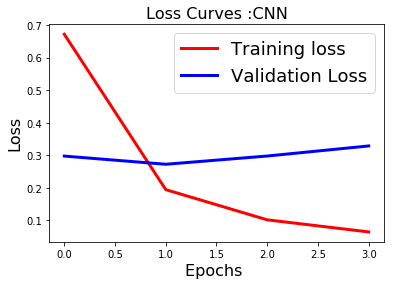

In [3]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

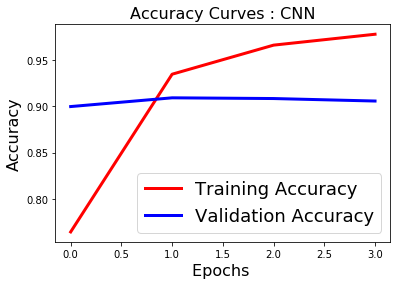

In [4]:
fig2=plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

### 模型结构打印

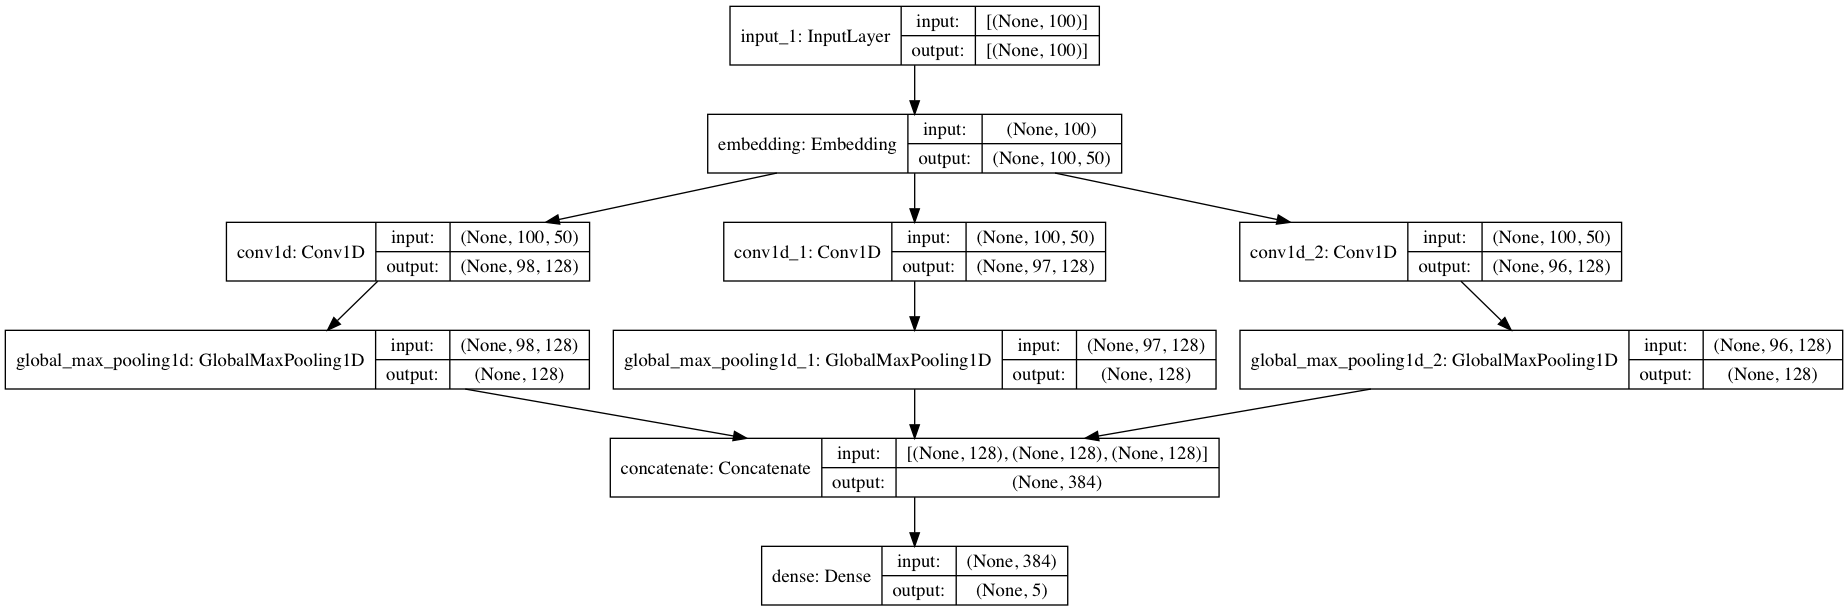

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)